C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is av

Training Set Metrics (SARIMAX):
{'RMSE': 755.750796641375, 'MSE': 571159.2666240729, 'MAE': 516.1857006611691, 'MAPE': 61.60498918448166}

Validation Set Metrics (SARIMAX):
{'RMSE': 1956.0444620268377, 'MSE': 3826109.937425861, 'MAE': 1734.0938144142397, 'MAPE': 150.28258305245444}


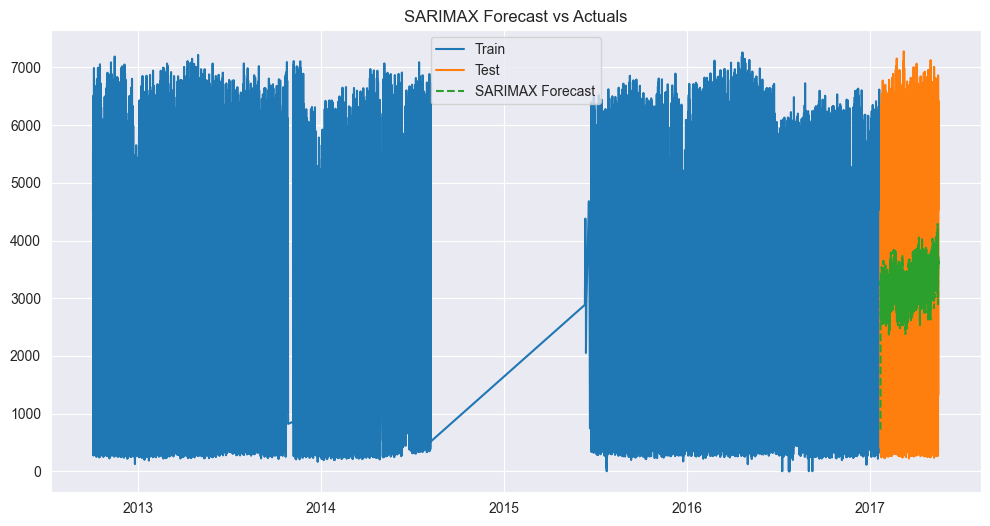

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Load the dataset
df_raw = pd.read_csv('../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']

# Split the data into train and test sets
total_samples = df.shape[0]
split_index = int(total_samples * 0.9)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Fit the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(3, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Save the trained SARIMAX model
joblib.dump(results, 'sarimax_model.joblib')

# Make predictions on the validation set
predictions_sarimax = results.get_forecast(steps=len(X_test), exog=X_test)
predicted_traffic_volume_sarimax = predictions_sarimax.predicted_mean

# Evaluate metrics on the training set for SARIMAX
train_metrics_sarimax = {
    'RMSE': np.sqrt(mean_squared_error(y_train, results.fittedvalues)),
    'MSE': mean_squared_error(y_train, results.fittedvalues),
    'MAE': mean_absolute_error(y_train, results.fittedvalues),
    'MAPE': mape_scorer(y_train, results.fittedvalues)
}

# Evaluate metrics on the validation set for SARIMAX
val_metrics_sarimax = {
    'RMSE': np.sqrt(mean_squared_error(y_test, predicted_traffic_volume_sarimax)),
    'MSE': mean_squared_error(y_test, predicted_traffic_volume_sarimax),
    'MAE': mean_absolute_error(y_test, predicted_traffic_volume_sarimax),
    'MAPE': mape_scorer(y_test, predicted_traffic_volume_sarimax)
}

# Print and compare metrics for SARIMAX
print("Training Set Metrics (SARIMAX):")
print(train_metrics_sarimax)

print("\nValidation Set Metrics (SARIMAX):")
print(val_metrics_sarimax)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, predicted_traffic_volume_sarimax, label='SARIMAX Forecast', linestyle='--')
plt.legend()
plt.title('SARIMAX Forecast vs Actuals')
plt.show()


C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


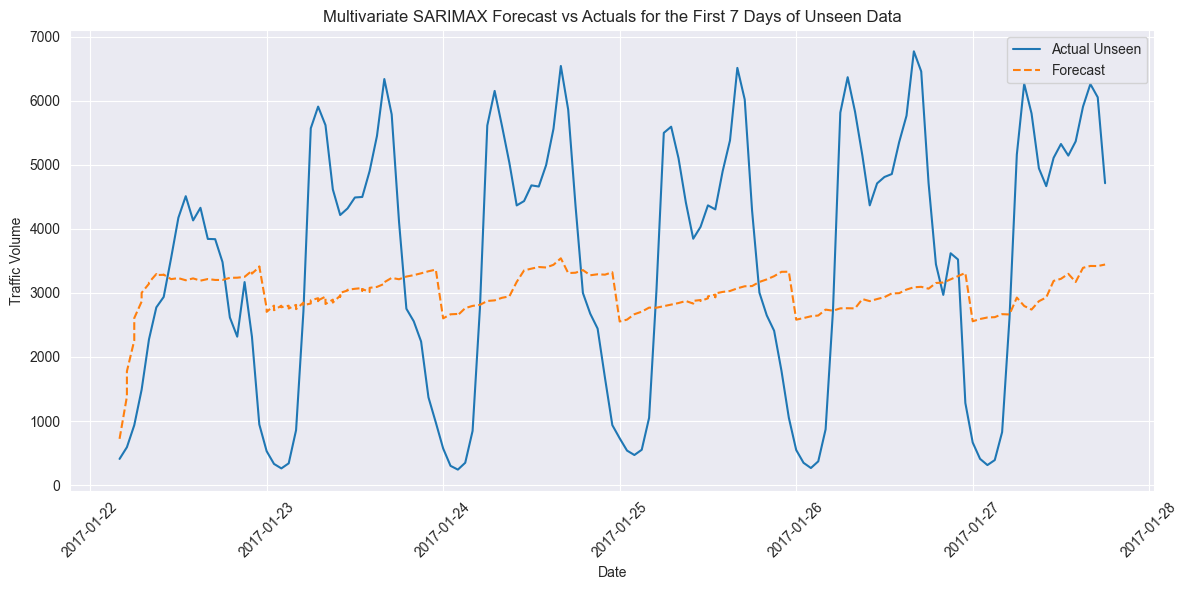

In [8]:
# Make predictions on the first 7 days of unseen data
forecast_unseen = results.get_forecast(steps=7*24, exog=X_test.iloc[:7*24])
predicted_traffic_volume_unseen = forecast_unseen.predicted_mean

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:7*24], y_test[:7*24], label='Actual Unseen')
plt.plot(y_test.index[:7*24], predicted_traffic_volume_unseen, label='Forecast', linestyle='--')
plt.legend()
plt.title('Multivariate SARIMAX Forecast vs Actuals for the First 7 Days of Unseen Data')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
